# Pre-Processing : Library and Data file import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)
pd.set_option('display.max_columns', 999)

In [1016]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import gc

In [987]:
import warnings
warnings.filterwarnings("ignore")

In [1017]:
gc.collect()

49975

In [919]:
#electronics = pd.read_pickle("df.pkl")

# 1. Processing data for appropriate Date-Time Values

In [920]:
df = electronics[:5000].copy()
df.drop('category_id',axis=1,inplace=True)

In [921]:
df['event_time'] = pd.DatetimeIndex(df['event_time']).tz_convert('US/Eastern')

In [922]:
df['year'] = pd.DatetimeIndex(df['event_time']).year
df['month'] = pd.DatetimeIndex(df['event_time']).month

In [923]:
# Month

MM = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df['month'] = pd.DatetimeIndex(df['event_time']).month.map(MM)

In [924]:
# Weekday

dayOfWeek={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fr', 5:'Sat', 6:'Sun'}
df['weekday'] = pd.DatetimeIndex(df['event_time']).weekday.map(dayOfWeek)

In [925]:
# Phase of day

df['hour'] = pd.DatetimeIndex(df['event_time']).hour
timeOfDay={0:'Dawn',1:'Dawn',2:'Dawn',3:'Dawn',4:'Dawn',5:'EarlyMorning',6:'EarlyMorning',7:'EarlyMorning',8:'EarlyMorning', 9:'Morning',10:'Morning',11:'Morning', 12:'Noon', 13:'Afternoon',14:'Afternoon',15:'Afternoon',16:'Afternoon', 17:'Evening',18:'Evening',19:'Evening',20:'Evening', 21:'Night',22:'Night',23:'Night', 24:'Midnight'}
df['timeOfDay'] = df.hour.map(timeOfDay)

In [926]:
# Is Weekend?

df['Weekend']= df.weekday.apply(lambda x : 1 if x in ['Sunday','Saturday'] else 0)

In [927]:
#Is holiday?
holidaysDF = pd.read_csv("holidays.csv")

holidaysDF['Date']= pd.DatetimeIndex(holidaysDF['Date']).tz_localize('UTC').tz_convert('US/Eastern')
holidaysList = []
for item in holidaysDF['Date'].to_list():
    holidaysList.append(pd.Timestamp(item))

Holiday = df.event_time.apply(lambda x : 1 if x in holidaysList else 0)
df['Holiday']= Holiday

In [928]:
df.head(3)

,user_id,product_id,user_session,event_time,event_type,category_code,brand,price,year,month,weekday,hour,timeOfDay,Weekend,Holiday
1,554748717,3900821,9333dfbd-b87a-4708-9857-6336556b0fcc,2019-09-30 20:00:00-04:00,view,appliances.environment.water_heater,aqua,33.20,2019,Sep,Mon,20,Evening,0,0
3,550050854,1307067,7c90fc70-0e80-4590-96f3-13c02c18c713,2019-09-30 20:00:01-04:00,view,computers.notebook,lenovo,251.74,2019,Sep,Mon,20,Evening,0,0
4,535871217,1004237,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,2019-09-30 20:00:04-04:00,view,electronics.smartphone,apple,1081.98,2019,Sep,Mon,20,Evening,0,0


# 2. Creating Features

## Features to build:

    Weekday(Sun/Mon/...) [One hot encoded]
    Month [One hot encoded]
    TimeOfDay(Morning/Evening/....) [One hot encoded]
    InteractionTime(Duration of Session in seconds)
    
    #TotalEventsInSession()
    #ViewEventsInSession
    #CartEventsInSession
    
    #CategoriesViewedInSession
    #CategoriesCartedInSession
    #BrandsViewedInSession
    #BrandsCartedInSession
    #ProductsViewedInSession
    #ProductsCartedInSession
    
    AverageAmountViewedInSession
    AverageAmountCartedInSession
    
    #HolidaysDuringSession()
    #WeekendDuringSession()
    
    LastSession(1: if the Session is last for a user, 0 if not)
    
    ViewToCartTime (Time between viewing and carting in session)
    
    Other suggested Features:
        AvgPRDViewbyUser (total products viewed/total sessions by user)
        AvgPRDCartbyUser  (total products carted/total sessions by user)
        AvgCTGViewbyUser (total categories viewed/total sessions by user)
        AvgCTGCartbyUser (total categories viewed/total sessions by user)

## ADDING COLUMNS TO DF -  AMOUNT BY USER FOR DIFFERENT EVENTS

In [929]:
AmountbyUser = pd.pivot_table(df, index='user_id',columns='event_type',values='price',fill_value=0)
AmountbyUser = AmountbyUser.rename(columns={'cart':'OverallAmtUserCarted','purchase':'OverallAmtUserPurchased','view':'OverallAmtUserViewed'})
df = pd.merge(df,AmountbyUser,on='user_id',how='outer')

## GROUPING THE DATA

In [930]:
GroupUS = df.sort_values('event_time').groupby(['user_session'])

## Total Number of Events/Interactions in Session

In [931]:
Features= GroupUS['event_type'].count().reset_index().rename(columns={'event_type':'TotalEventsInSession'})

## Duration

In [932]:
# # Defining function to return range of any given series
# def ammd(series):
#     return (max(series)-min(series))

In [933]:
interactionTime = GroupUS['event_time'].agg(ammd)
interactionTime = interactionTime.dt.total_seconds()
Features = pd.merge(Features,interactionTime, how ='outer', on = ['user_session'])
Features = Features.rename(columns={'event_time':'interactionTime'})

##  Number of Interactions by Event Type in Session

In [934]:
NumEventTime = GroupUS['event_type'].value_counts().unstack(fill_value = 0).rename(columns={'view':'#TimesViewedinSession','cart':'#TimesCartedinSession','purchase':'#TimesPurchasedinSession'})
Features = pd.merge(Features,NumEventTime, how ='outer', on = ['user_session'])

## Max and Min Price

In [935]:
Features['maxPrice'] = GroupUS['price'].max().values
Features['minPrice'] = GroupUS['price'].min().values

## AVERAGE AMOUNT BY EVENT IN SESSION

In [936]:
AmountbyEvent = pd.pivot_table(df, index='user_session',columns='event_type',values='price',fill_value=0)
AmountbyEvent = AmountbyEvent.rename(columns={'cart':'AvgAmtCartedInSession','purchase':'AvgAmtPurchasedInSession','view':'AvgAmtViewedInSession'})
Features = pd.merge(Features,AmountbyEvent,on='user_session',how='outer')

## BRAND COUNT BY EVENT IN SESSION

In [937]:
BrandsBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='brand',aggfunc='count',fill_value=0)
BrandsBySession = BrandsBySession.rename(columns={'view':'#BrandsViewedInSession','cart':'#BrandsCartedInSession','purchase':'#BrandsPurchasedInSession'})
Features = pd.merge(Features,BrandsBySession,on='user_session',how='outer')

## CATEGORY COUNT BY EVENT IN SESSION

In [938]:
CategoriesBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='category_code',aggfunc='count',fill_value=0)
CategoriesBySession = CategoriesBySession.rename(columns={'view':'#CategoriesViewedInSession','cart':'#CategoriesCartedInSession','purchase':'#CategoriesPurchasedInSession'})
Features = pd.merge(Features,CategoriesBySession,on='user_session',how='outer')

In [939]:
Features.head(1)

,user_session,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesPurchasedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsPurchasedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesPurchasedInSession,#CategoriesViewedInSession
0,00334c2e-e8e5-463f-ae4e-f44f9796ccf4,2,54.0,0,0,2,1541.61,1541.61,0.0,0.0,1541.61,0,0,2,0,0,2


## ADDING FEATURES FOR AVERAGE OVERALL AMOUNT BY USER FOR DIFFERENT EVENTS

In [940]:
OverallAmtUserCarted = df.groupby('user_session')['OverallAmtUserCarted'].mean()
OverallAmtUserViewed = df.groupby('user_session')['OverallAmtUserViewed'].mean()
OverallAmtUserPurchased = df.groupby('user_session')['OverallAmtUserPurchased'].mean()

#Merging these individual dataframes

Features = pd.merge(Features,OverallAmtUserCarted.reset_index(), how='outer',on = ['user_session'])
Features = pd.merge(Features,OverallAmtUserViewed.reset_index(), how='outer',on = ['user_session'])
Features = pd.merge(Features,OverallAmtUserPurchased.reset_index(), how='outer',on = ['user_session'])

In [941]:
Features.head(1)

,user_session,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesPurchasedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsPurchasedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesPurchasedInSession,#CategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased
0,00334c2e-e8e5-463f-ae4e-f44f9796ccf4,2,54.0,0,0,2,1541.61,1541.61,0.0,0.0,1541.61,0,0,2,0,0,2,0.0,1541.61,0.0


## PRODUCT COUNT BY EVENT IN SESSION

In [942]:
ProductsBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='product_id',aggfunc='count',fill_value=0)
ProductsBySession = ProductsBySession.rename(columns={'view':'#ProdsViewedInSession','cart':'#ProdsCartedInSession','purchase':'#ProdsPurchasedInSession'})
Features = pd.merge(Features,ProductsBySession,on='user_session',how='outer')

In [943]:
Features.head(1)

,user_session,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesPurchasedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsPurchasedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesPurchasedInSession,#CategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased,#ProdsCartedInSession,#ProdsPurchasedInSession,#ProdsViewedInSession
0,00334c2e-e8e5-463f-ae4e-f44f9796ccf4,2,54.0,0,0,2,1541.61,1541.61,0.0,0.0,1541.61,0,0,2,0,0,2,0.0,1541.61,0.0,0,0,2


****************************************

Adding a dummy column for one-hot encoding values easily

In [944]:
df['dummy']= np.zeros(len(df))

## Adding Date and Time Features 

In [945]:
weekday = pd.pivot_table(df, index='user_session',columns='weekday',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

In [946]:
year =  pd.pivot_table(df, index='user_session',columns='year',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

In [947]:
month =  pd.pivot_table(df, index='user_session',columns='month',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

In [948]:
timeOfDay =  pd.pivot_table(df, index='user_session',columns='timeOfDay',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

In [949]:
Features = pd.merge(Features,weekday,on='user_session',how='outer')
Features = pd.merge(Features,year,on='user_session',how='outer')
Features = pd.merge(Features,month,on='user_session',how='outer')
Features = pd.merge(Features,timeOfDay,on='user_session',how='outer')

In [950]:
Features.head(1)

,user_session,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesPurchasedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsPurchasedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesPurchasedInSession,#CategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased,#ProdsCartedInSession,#ProdsPurchasedInSession,#ProdsViewedInSession,Mon,2019,Sep,Evening,Night
0,00334c2e-e8e5-463f-ae4e-f44f9796ccf4,2,54.0,0,0,2,1541.61,1541.61,0.0,0.0,1541.61,0,0,2,0,0,2,0.0,1541.61,0.0,0,0,2,1,1,1,1,0


In [951]:
Holiday = GroupUS['Holiday'].sum()
Weekend = GroupUS['Weekend'].sum()

In [952]:
Features = pd.merge(Features,Holiday,on='user_session',how='outer')
Features = pd.merge(Features,Weekend,on='user_session',how='outer')

## Dropping all Purchase related Columns and adding Y label 'Purchase'

In [953]:
Features['Purchase'] = Features.AvgAmtPurchasedInSession.apply(lambda x : 1 if x!=0 else 0)

In [955]:
Features.columns

Index([                 'user_session',          'TotalEventsInSession',
                     'interactionTime',         '#TimesCartedinSession',
            '#TimesPurchasedinSession',         '#TimesViewedinSession',
                            'maxPrice',                      'minPrice',
               'AvgAmtCartedInSession',      'AvgAmtPurchasedInSession',
               'AvgAmtViewedInSession',        '#BrandsCartedInSession',
           '#BrandsPurchasedInSession',        '#BrandsViewedInSession',
          '#CategoriesCartedInSession', '#CategoriesPurchasedInSession',
          '#CategoriesViewedInSession',          'OverallAmtUserCarted',
                'OverallAmtUserViewed',       'OverallAmtUserPurchased',
               '#ProdsCartedInSession',      '#ProdsPurchasedInSession',
               '#ProdsViewedInSession',                           'Mon',
                                  2019,                           'Sep',
                             'Evening',            

In [960]:
FeaturesDF = Features.drop(columns=['user_session',
                                    '#TimesPurchasedinSession',
                                    '#BrandsPurchasedInSession', 
                                    'AvgAmtPurchasedInSession',
                                    '#CategoriesPurchasedInSession',
                                   'OverallAmtUserPurchased',
                                   '#ProdsPurchasedInSession'])

In [962]:
FeaturesDF.sort_values(by='Purchase',ascending=False)

,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,#ProdsCartedInSession,#ProdsViewedInSession,Mon,2019,Sep,Evening,Night,Holiday,Weekend,Purchase
251,26,790.0,0,25,2075.73,66.41,0.00,324.784800,0,25,0,25,0.00,324.784800,0,25,1,1,1,0,1,0,0,1
1608,10,469.0,2,7,386.08,296.80,385.82,354.861429,2,7,2,7,385.82,354.861429,2,7,1,1,1,0,1,0,0,1
533,5,481.0,1,3,189.26,164.71,189.26,181.076667,1,3,1,3,189.26,181.076667,1,3,1,1,1,0,1,0,0,1
1202,2,54.0,0,1,3.37,3.37,0.00,3.370000,0,1,0,1,0.00,1.710000,0,1,1,1,1,0,1,0,0,1
1347,4,85.0,2,1,89.32,89.32,89.32,89.320000,2,1,2,1,89.32,89.320000,2,1,1,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,3,50.0,0,3,171.56,161.98,0.00,165.173333,0,3,0,3,0.00,165.173333,0,3,1,1,1,0,1,0,0,0
578,1,0.0,0,1,58.95,58.95,0.00,58.950000,0,1,0,1,0.00,58.950000,0,1,1,1,1,0,1,0,0,0
577,1,0.0,0,1,397.95,397.95,0.00,397.950000,0,1,0,1,0.00,397.950000,0,1,1,1,1,0,1,0,0,0
576,3,53.0,0,3,464.13,360.08,0.00,394.763333,0,3,0,3,0.00,394.763333,0,3,1,1,1,0,1,0,0,0


In [981]:
display("The features we have are as follows:", FeaturesDF.columns.tolist())

print('************')
print("PLEASE NOTE THAT \n One-Hot-Encoded Date and Time features are dynamically added as per data")
print('************')

'The features we have are as follows:'

['TotalEventsInSession',
 'interactionTime',
 '#TimesCartedinSession',
 '#TimesViewedinSession',
 'maxPrice',
 'minPrice',
 'AvgAmtCartedInSession',
 'AvgAmtViewedInSession',
 '#BrandsCartedInSession',
 '#BrandsViewedInSession',
 '#CategoriesCartedInSession',
 '#CategoriesViewedInSession',
 'OverallAmtUserCarted',
 'OverallAmtUserViewed',
 '#ProdsCartedInSession',
 '#ProdsViewedInSession',
 'Mon',
 2019,
 'Sep',
 'Evening',
 'Night',
 'Holiday',
 'Weekend',
 'Purchase']

************
PLEASE NOTE THAT 
 One-Hot-Encoded Date and Time features are dynamically added as per data
************


# 3. Feature Ranking

## Preparing Training and Testing Data

In [982]:
XData = FeaturesDF.loc[:,:'Weekend']
YData = FeaturesDF.loc[:,'Purchase']

In [984]:
XData

,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,#ProdsCartedInSession,#ProdsViewedInSession,Mon,2019,Sep,Evening,Night,Holiday,Weekend
0,2,54.0,0,2,1541.61,1541.61,0.0,1541.610000,0,2,0,2,0.0,1541.610000,0,2,1,1,1,1,0,0,0
1,1,0.0,0,1,124.45,124.45,0.0,124.450000,0,1,0,1,0.0,124.450000,0,1,1,1,1,0,1,0,0
2,1,0.0,0,1,70.76,70.76,0.0,70.760000,0,1,0,1,0.0,70.760000,0,1,1,1,1,0,1,0,0
3,2,55.0,0,2,284.69,284.69,0.0,284.690000,0,2,0,2,0.0,673.376429,0,2,1,1,1,0,1,0,0
4,1,0.0,0,1,141.86,141.86,0.0,141.860000,0,1,0,1,0.0,141.860000,0,1,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,1,0.0,0,1,1445.34,1445.34,0.0,1445.340000,0,1,0,1,0.0,1445.340000,0,1,1,1,1,0,1,0,0
1705,1,0.0,0,1,191.77,191.77,0.0,191.770000,0,1,0,1,0.0,191.770000,0,1,1,1,1,0,1,0,0
1706,3,160.0,0,3,41.16,7.85,0.0,23.193333,0,3,0,3,0.0,33.160000,0,3,1,1,1,0,1,0,0
1707,2,4.0,0,2,77.20,77.20,0.0,77.200000,0,2,0,2,0.0,77.200000,0,2,1,1,1,0,1,0,0


In [989]:
X_train, X_test, y_train, y_test = train_test_split(XData,YData,test_size=0.2,random_state=42)

SCALING DATA WITH MINMAX SCALER

In [990]:
MMscaler = MinMaxScaler()
X_train = MMscaler.fit_transform(X_train)
X_test = MMscaler.transform(X_test)

## USING RANDOM FOREST

In [992]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))

In [993]:
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [994]:
sel.get_support()

array([ True,  True, False,  True,  True,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True, False, False,
       False, False, False, False, False])

In [996]:
selected_feat= XData.columns[(sel.get_support())]

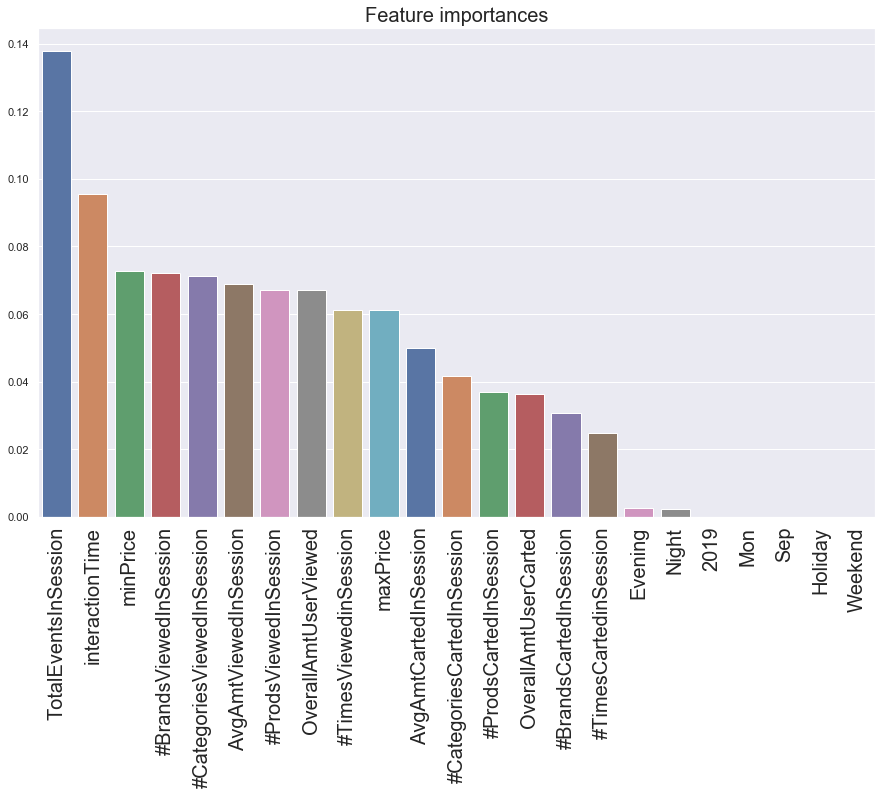

In [998]:
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1] 
colname = XData.columns[indices]
plt.figure(figsize=(15,9))
plt.title("Feature importances",size=20)
sns.barplot(x=colname, y=importances[indices],palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()

## Using F Scores

In [1001]:
import sklearn.feature_selection as fs
kb = fs.SelectKBest(k=X_train.shape[1])
kb.fit(X_train, y_train)
names = XData.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))

In [1002]:
fScoreDF = pd.DataFrame(data = names_scores, columns=['Feat_names','F_Scores'])
fScoreDF_sorted = fScoreDF.sort_values(['F_Scores','Feat_names'], ascending =[False, True])

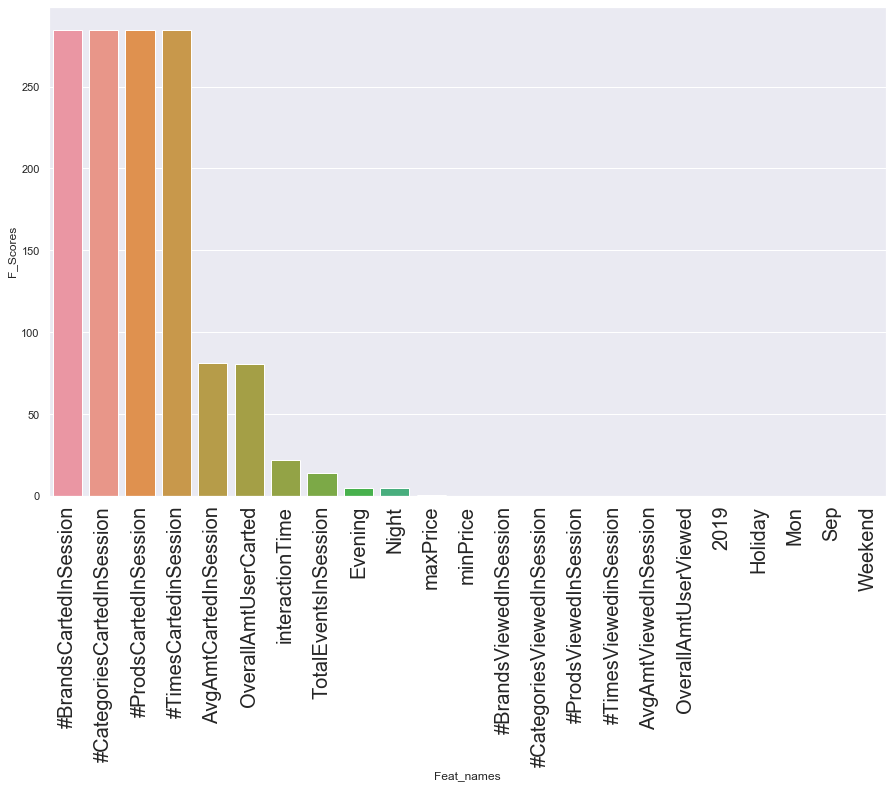

In [1003]:
plt.figure(figsize=(15,9))
sns.barplot(x= "Feat_names", y="F_Scores",data=fScoreDF_sorted)
plt.xticks(rotation=90,size=20)
plt.show()

# BASELINING --- TO BE DONE

## Using KNN

In [1005]:
pca = PCA(.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [1006]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [1009]:
classifier = KNeighborsClassifier(n_neighbors = 4)

In [1010]:
y_pred = cross_val_predict(classifier, X_train, y_train, cv=5)

In [1011]:
print(metrics.accuracy_score(y_train, y_pred))

0.9604974396488661


In [1012]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [1013]:
predFinal = classifier.predict(X_test)

In [1014]:
print(metrics.accuracy_score(y_test, predFinal))

0.9473684210526315


In [1018]:
cnf_matrix = confusion_matrix(y_test, predFinal)
cnf_matrix

array([[324,   1],
       [ 17,   0]])

Text(0.5, 3.5, 'Predicted label')

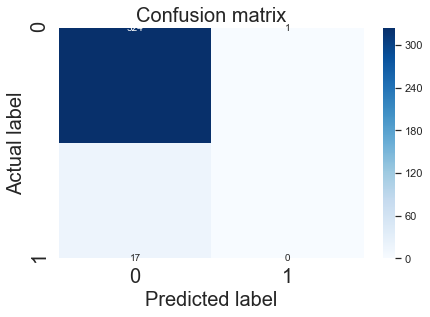

In [1019]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,size=20)
plt.yticks(tick_marks, class_names,size=20)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix',size = 20)
plt.ylabel('Actual label',size = 20)
plt.xlabel('Predicted label',size = 20)

## Using LR